# Tutorial de transfer learning
https://youtu.be/Y_WAXe4LprY

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [32]:
import matplotlib.pyplot as plt

# Descargar sets de datos

In [33]:
DATA_PATH = './cifar-10/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_imagenes = T.Compose([
    T.ToTensor(),
     T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
        
])


# Train
cifar10_train = datasets.CIFAR10(
    DATA_PATH,
    train=True,
    download=True,
    transform=transform_imagenet)

train_loader = DataLoader(
    cifar10_train,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation
cifar10_val =datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)

val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))


# Testing
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)        

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [35]:
classes = [
    'Plane',
    'Car',
    'Bird',
    'Cat',
    'Deer',
    'Dog',
    'Frog',
    'Horse',
    'Ship',
    'Truck'
]

In [36]:
def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: Truck


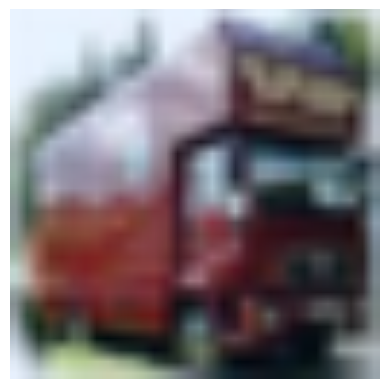

In [37]:


rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

In [38]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            pred = scores.argmax(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total 
            

# Loop de entrenamiento

In [39]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    global val_loader
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()     
    

In [14]:
# Instanciar model
hidden1 = 256
hidden = 256
out_features = 10
lr = 5e-4
epochs = 3
mb_size = 8
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3*224*224, out_features=hidden1),
    nn.ReLU(),
    nn.Linear(in_features=hidden1, out_features=hidden),
    nn.ReLU(),
    nn.Linear(in_features=hidden, out_features=out_features),
)
optimizer = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

train(model1, optimiser=optimizer, epochs=epochs)

Epoch: 0, costo: 1.823500633239746, accuracy: 0.379,
Epoch: 1, costo: 1.3890870809555054, accuracy: 0.4234,
Epoch: 2, costo: 1.4761879444122314, accuracy: 0.451,


In [41]:
accuracy(model1, test_loader)

0.0945

# Cargar modelo pre-cargado

In [54]:
model_resnet18 = models.resnet18(weights=True)


# Explorar el modelo

In [55]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [56]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
model_aux = nn.Sequential(*list(model_resnet18.children()))


In [58]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])


In [59]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [60]:
# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))


Files already downloaded and verified


In [61]:

hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 5
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [62]:
train(model1, optimiser, epochs)


Epoch: 0, costo: 1.135777235031128, accuracy: 0.7766,
Epoch: 1, costo: 0.9943382740020752, accuracy: 0.7936,
Epoch: 2, costo: 0.340749055147171, accuracy: 0.7956,
Epoch: 3, costo: 1.3563148975372314, accuracy: 0.8016,
Epoch: 4, costo: 0.7142436504364014, accuracy: 0.8028,


In [63]:
accuracy(model1, test_loader)

0.7969